# DistilBERT

DistilBERT is a smaller, more efficient student model of BERT-base, where knowledge distillation has been used to capture information learnt by the pre-trained BERT-base model into fewer parameters. Specifically DistilBert has 66 million parameters, while BERT-base has 110 million[1]. This is because DistilBERT has half of the layers used in BERT removed, as well as the token-type embeddings and the pooler. Experiments in [1] found DistilBERT to be 60% faster than BERT while retaining 97% of BERT's performance. The distillation is implemented by training with distillation loss, for which the formula is given by

$$ L_{ce} = \sum_{i} t_{i} \times \log(s_i), $$
where $t_i$ is the probability estimated by the teacher model and $s_i$ is the probability estimated by the student model.

This is a cross entropy loss function which means in training the DistilBert minimises the difference between the BERT probabilites and its own. This model is combined with the masked language modelling loss ($L_{mlm})$ used by the original BERT model. MLM works by randomly selecting tokens at random to 'mask', and then predicting what those masked tokens are, again with cross entropy loss. In the BERT-base model 15% of tokens are masked [2].

The code for this model builds from the code used to fine-tune FinBERT in section 2 and is also adapted from examples in [4].

To run the DistilBERT model we use the same dataset and label mapping used in section 2 for the FinBERT model.

In [13]:
#Package requirements

!pip install -U transformers
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 86.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.9 MB/s eta 0:00:00


In [1]:
#Load dataset
from datasets import load_dataset
ds2 = load_dataset("FinGPT/fingpt-sentiment-train", split="train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/529 [00:00<?, ?B/s]

data/train-00000-of-00001-dabab110260ac9(…):   0%|          | 0.00/6.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/76772 [00:00<?, ? examples/s]

In [2]:
# Map labels because dataset came with 9 labels but we want 5
mapping_5 = {
    "strong negative": "negative",
    "moderately negative": "moderate_negative",
    "mildly negative": "moderate_negative",
    "negative": "negative",
    "neutral": "neutral",
    "mildly positive": "moderate_positive",
    "moderately positive": "moderate_positive",
    "positive": "positive",
    "strong positive": "positive"
}

In [3]:
def map_to_5(example):
    example["label_5"] = mapping_5[example["output"]]
    return example

ds2 = ds2.map(map_to_5)
unique_new = sorted(list(set(ds2["label_5"])))
id2label = {i: lab for i, lab in enumerate(unique_new)}
label2id = {lab: i for i, lab in id2label.items()}

def encode_label(id):
    id["label"] = label2id[id["label_5"]]
    return id

ds2 = ds2.map(encode_label)
print(ds2.column_names)

Map:   0%|          | 0/76772 [00:00<?, ? examples/s]

Map:   0%|          | 0/76772 [00:00<?, ? examples/s]

['input', 'output', 'instruction', 'label_5', 'label']


## Model 1 - no fine-tuning

Before we begin any fine tuning we do an intial run of the model to see how it performs with default settings and parameters.

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model1 = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels = 5,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

def tokenize(batch):
    return tokenizer(batch["input"], truncation=True, padding="max_length", max_length=128)

ds2 = ds2.map(tokenize, batched=True)
ds2 = ds2.train_test_split(test_size=0.2)   # create validation set

ds2 = ds2.remove_columns(["output", "label_5", "input"])  # keep only tokenized fields + label
ds2.set_format("torch")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/76772 [00:00<?, ? examples/s]

In [19]:
print(ds2.column_names)


{'train': ['instruction', 'label', 'input_ids', 'attention_mask'], 'test': ['instruction', 'label', 'input_ids', 'attention_mask']}


We also use the same trainer call back to measure training accuracy and record the predictions.

In [5]:
from transformers import TrainerCallback
import numpy as np
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F

class TrainAccuracyCallback(TrainerCallback):
    def __init__(self):
        self.trainer = None  # Will be set after Trainer initialization

    def on_epoch_end(self, args, state, control, **kwargs):
        if self.trainer is None:
            # This case should ideally not be reached if setup correctly
            raise ValueError("Trainer instance not set in TrainAccuracyCallback.")

        train_ds = self.trainer.train_dataset

        # Get predictions on the training set
        preds_output = self.trainer.predict(train_ds, metric_key_prefix="train")
        logits = preds_output.predictions
        labels = preds_output.label_ids
        preds = np.argmax(logits, axis=1)

        # Compute accuracy
        train_acc = (preds == labels).mean()

        # Log accuracy into trainer history
        self.trainer.state.log_history.append({
            "epoch": state.epoch,
            "train_accuracy": train_acc,
            "step": state.global_step
        })

        print(f"Training Accuracy (epoch {state.epoch:.0f}): {train_acc:.4f}")

We train the model

In [40]:
from transformers import TrainingArguments, Trainer
import numpy as np
from evaluate import load

metric = load("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": metric.compute(predictions=preds, references=labels)["accuracy"]}

training_args = TrainingArguments(
    output_dir="./distilbert_5class",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,

    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True,
    report_to="none"
)

# Instantiate the custom callback
train_acc_callback = TrainAccuracyCallback()

trainer = Trainer(
    model=model1,
    args=training_args,
    train_dataset=ds2["train"],
    eval_dataset=ds2["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[train_acc_callback] # Pass the instance here
)

# After the Trainer is initialized, assign the trainer instance to the callback
train_acc_callback.trainer = trainer

trainer.train()

/tmp/ipython-input-3496565030.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.280800,0.261237,0.917551
2,0.182500,0.245601,0.932595
3,0.106000,0.281983,0.937480
4,0.078600,0.354948,0.935982
5,0.031000,0.397184,0.937024


Training Accuracy (epoch 1): 0.9453
Training Accuracy (epoch 2): 0.9737
Training Accuracy (epoch 3): 0.9851
Training Accuracy (epoch 4): 0.9935
Training Accuracy (epoch 5): 0.9966


TrainOutput(global_step=19195, training_loss=0.15832766540102053, metrics={'train_runtime': 1726.8704, 'train_samples_per_second': 177.827, 'train_steps_per_second': 11.115, 'total_flos': 1.01702318649024e+16, 'train_loss': 0.15832766540102053, 'epoch': 5.0})

## Model 1 Results

Below we plot the accuracy and loss curves, and also a confusion matrix to look at the model's performance in more detail

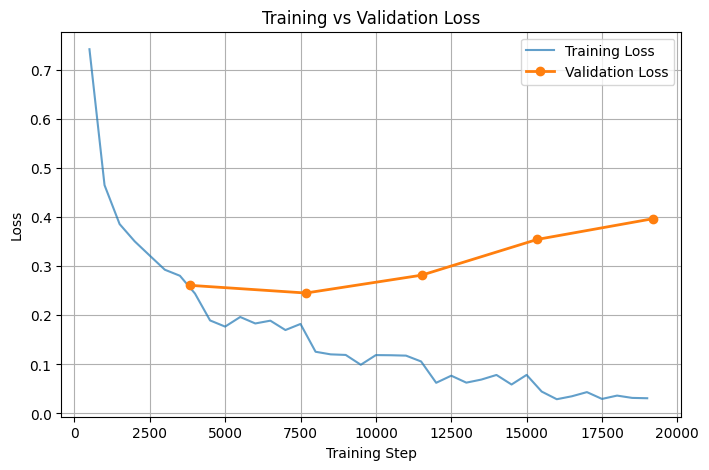

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# Load logs
logs = pd.DataFrame(trainer.state.log_history)

train_loss = logs.dropna(subset=["loss"])
eval_loss = logs.dropna(subset=["eval_loss"])

plt.figure(figsize=(8,5))

# Training loss is logged per step
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss", alpha=0.7)

# Validation loss is logged per epoch, so use epoch instead of step
plt.plot(eval_loss["step"], eval_loss["eval_loss"], marker="o", label="Validation Loss", linewidth=2)

plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

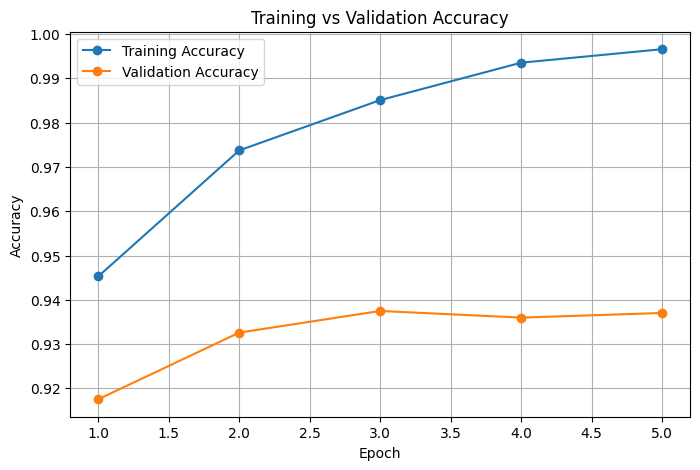

In [42]:
logs = pd.DataFrame(trainer.state.log_history)

train_acc = logs.dropna(subset=["train_accuracy"])
eval_acc = logs.dropna(subset=["eval_accuracy"])

plt.figure(figsize=(8,5))

plt.plot(train_acc["epoch"], train_acc["train_accuracy"], marker="o", label="Training Accuracy")
plt.plot(eval_acc["epoch"], eval_acc["eval_accuracy"], marker="o", label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

The plots above show that DistilBERT performs quite well without any fine-tuning. It generalised to the data quite well with a high test accuracy. However the validation loss steadily increases with each epoch and the resulting loss is quite high at almost 0.4. We can fine-tune the model to reduce this loss and potentially increase test accuracy as well.

In [43]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions to produce confusion matrix
preds_output1 = trainer.predict(trainer.eval_dataset)
preds = np.argmax(preds_output1.predictions, axis=1)

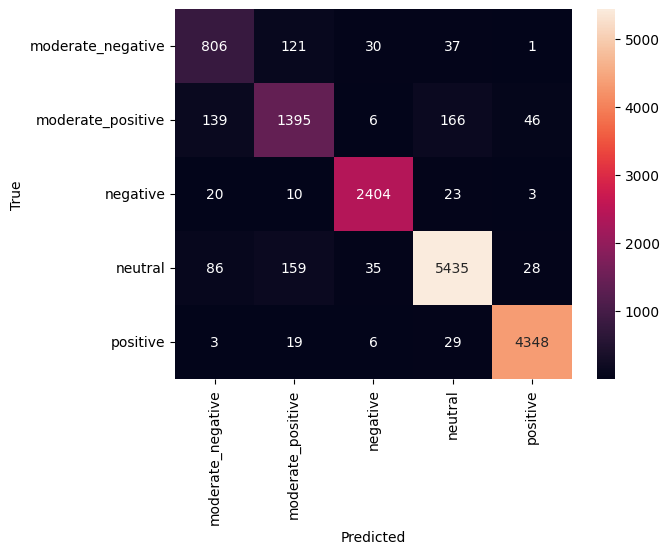

In [44]:
labels = ds2["test"]["label"]

cm = confusion_matrix(preds, labels)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The confusion matrix shows the model struggles to predict the moderate negative and moderate positive classes, which is what we would expect when predicting the minority classes in a very imbalanced dataset. These incorrect predictions may be responsible for most of the validation loss.

# Model 2 - reducing loss

 A first attempt at fine-tuning included changing the learning rate from $5e^{-5}$ to $2e^{-5}$ and adding an attention dropout probability of 0.2. These changes didn't offer any improvements.

The high validation loss despite high accuracy may be due to how the cross entropy loss function works. The formula for the penalty calculated with cross entropy loss for a multiclass problem is as follows:

$$L = - \sum^K_{k=1} y_k \log (\hat{y_k})$$
where $y$ is the true label, and $\hat{y}$ is the probability of that label calculated by the model [3]. This probability can be interpreted as how confident the model is on that label, ranging from 0 to 1. Using the logits means overconfident mistakes produce high loss and underconfident correct predictions produce moderate loss.

To reduce this loss we decrease dropout from 0.2 to 0.05. We also introduce different learning rates for different layers of the model. This is called layer-wise learning rates and is discussed in 'Initializing the Layer-wise Learning Rate' [5]. In this study layer-wise learning rates were implemented in a CNN and found lower learning rates are more suited for deeper layers, and higher learning rates are better for high-level layer.

The DistilBERT model has a set of transformer layers which learn the context of the words. The transformer layers is where the model learns the most important information, where as the pre-classifier and classifier are initialised randomly and don't contain any of the pre-trained knowledge. Therefore the classifer needs larger adjustments at each step so we want a higher learning rate to increase loss convergence.
Therefore we customise the optimiser and set the learning rate for the 'distilbert' layer to $e^{-5}$ and the pre-classifer and classifer learning rates are both $2e^{-5}$.


In [26]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained(
    model_name,
    num_labels = 5,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    attention_dropout_prob = 0.05)


model2 = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config = config
)




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Define parameter groups and learning rates
from torch.optim import AdamW
from transformers import Trainer

def build_optimizer(model):
    return AdamW([
        {'params': model.distilbert.parameters(), 'lr': 1e-5},
        {'params': model.pre_classifier.parameters(), 'lr': 2e-5},
        {'params': model.classifier.parameters(), 'lr': 2e-5},
    ])

class CustomTrainer(Trainer):
    def create_optimizer(self):
        self.optimizer = build_optimizer(self.model)


In [28]:
from transformers import TrainingArguments

training_args2 = TrainingArguments(
    output_dir="./distilbert_5class",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True,
    report_to="none"
)

trainer2 = CustomTrainer(
    model=model2,
    args=training_args2,
    train_dataset=ds2["train"],
    eval_dataset=ds2["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[train_acc_callback] # Pass the instance here
)

# After the Trainer is initialized, assign the trainer instance to the callback
train_acc_callback.trainer = trainer2

trainer2.train()


/tmp/ipython-input-2740711675.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer2 = CustomTrainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.327600,0.278872,0.906350
2,0.216000,0.247090,0.927125
3,0.155700,0.256338,0.936047
4,0.131400,0.279207,0.937024
5,0.093900,0.301400,0.937740


Training Accuracy (epoch 1): 0.9332
Training Accuracy (epoch 2): 0.9605
Training Accuracy (epoch 3): 0.9726
Training Accuracy (epoch 4): 0.9805
Training Accuracy (epoch 5): 0.9827


TrainOutput(global_step=19195, training_loss=0.21314784231580897, metrics={'train_runtime': 1861.8584, 'train_samples_per_second': 164.935, 'train_steps_per_second': 10.31, 'total_flos': 1.01702318649024e+16, 'train_loss': 0.21314784231580897, 'epoch': 5.0})

## Model 2 Results

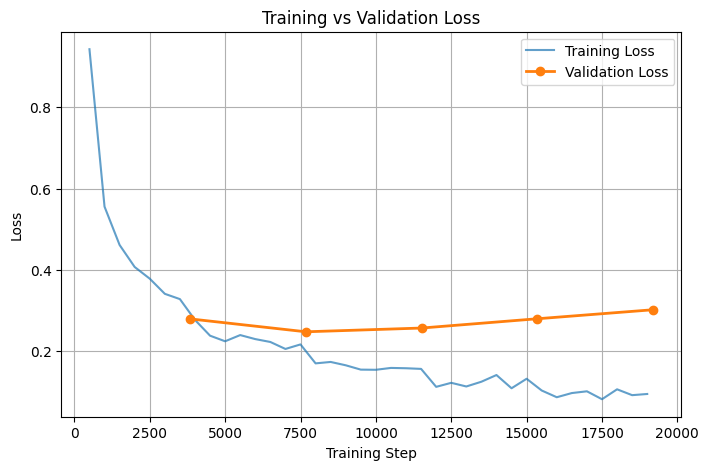

In [29]:


# Load logs
logs = pd.DataFrame(trainer2.state.log_history)

train_loss = logs.dropna(subset=["loss"])
eval_loss = logs.dropna(subset=["eval_loss"])

plt.figure(figsize=(8,5))

# Training loss is logged per step
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss", alpha=0.7)

# Validation loss is logged per epoch, so use epoch instead of step
plt.plot(eval_loss["step"], eval_loss["eval_loss"], marker="o", label="Validation Loss", linewidth=2)

plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

The plot above shows we have improved the convergence of the validation loss. It is still relatively high compared to the training loss but it means we have improved the confidence in our predictions.

In [37]:

preds_output2 = trainer2.predict(trainer2.eval_dataset)
preds = np.argmax(preds_output2.predictions, axis=1)


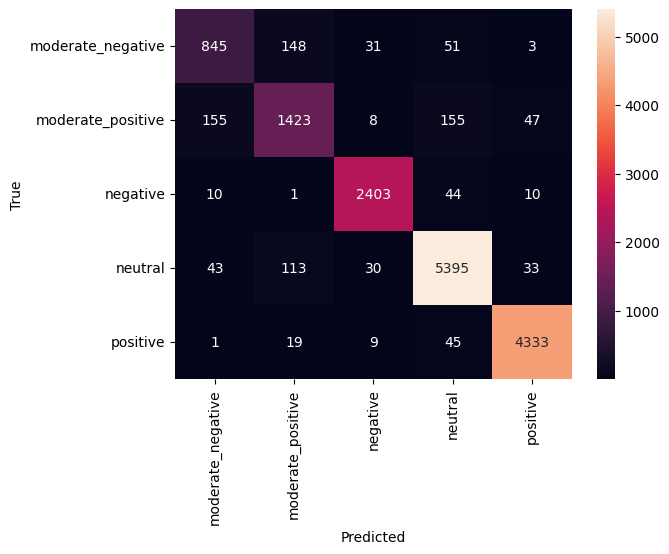

In [38]:


cm = confusion_matrix(preds, labels)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Although the accuracy has remained similar, and most of the incorrect predictions are still for the moderate positive and moderate negative classes, if we compare this confusion matrix with that from model 1 we can see that model 2 has more correct predictions for those two classes.

## Bibliography

[1] Sanh, V et al. (2019) 'DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter', CoRR
URL: https://doi.org/10.48550/arXiv.1910.01108

[2] Devlin, J et al. (2018)'BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding', CoRR
URL: https://arxiv.org/abs/1810.04805

[3] (2025) 'Cross-Entropy Loss: Simple Explanations, Maths Explained', Hugging Face
URL : https://huggingface.co/blog/royswastik/cross-entropy-simplified

[4] (2024)'Fine-Tuning DistilBERT: A Step-by-Step Practical Guide', Medium
URL : https://medium.com/@heyamit10/fine-tuning-distilbert-a-step-by-step-practical-guide-8eda046222b5

[5] Kwang, Y. S. et al. (2025),'Initializing the Layer-wise Learning Rate', ICLR 2025
URL: https://openreview.net/forum?id=ATCanNIk1H